<a href="https://colab.research.google.com/github/lennardwalter/multisensor/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git lfs install
!git clone https://github.com/lennardwalter/multisensor.git

Git LFS initialized.
Cloning into 'multisensor'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 617.12 KiB | 14.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies (run once)
%pip install -q pytorch-forecasting "lightning>=2.0.0" optuna pyarrow fastparquet pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 57.4 MB/s eta 0:00:00


In [ ]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import (
    Baseline,
    TemporalFusionTransformer,
    TimeSeriesDataSet,
)
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

pl.seed_everything(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Using device: cuda


In [ ]:
# Configuration
PARQUET_PATH = "multisensor/exports_last_100_days/multisensor.parquet"
META_PATH = "multisensor/exports_last_100_days/multisensor.parquet.meta.json"

# device selection; set to None to include all devices present
SELECTED_DEVICES = None

# metrics selection
# if empty/None, all metrics from meta will be used
METRICS_TO_USE = [
    "co2",
    "gas_resistance",
    "light",
    "voc_equivalent",
    "temperature",
    "humidity",
    "pressure",
]
TARGET_METRIC = "co2"

# resampling and fill
RESAMPLE_FREQ = "1min"
FILL_METHOD = "interpolate"  # one of: interpolate|ffill|bfill|none
FILL_LIMIT = 30

# inactivity filtering (row-level sparsity before fill)
MIN_ACTIVE_RATIO_DEFAULT = 0.08
MIN_ACTIVE_RATIO_BY_METRIC = {
    "co2": 0.8,
    "gas_resistance": 0.8,
    "light": 0.4,
    "voc_equivalent": 0.2,
    "temperature": 0.03,
}

# sequence lengths
MAX_ENCODER_LENGTH = 30
MAX_PREDICTION_LENGTH = 12

# training
BATCH_SIZE = 64
NUM_WORKERS = 0



In [ ]:
# Data loading and preprocessing

def _apply_fill(df: pd.DataFrame, method: str, limit: int | None) -> pd.DataFrame:
    if method == "none":
        # still respect limit for edge fills
        return df.ffill(limit=limit).bfill(limit=limit)
    if method == "ffill":
        return df.ffill(limit=limit).bfill(limit=limit)
    if method == "bfill":
        return df.bfill(limit=limit).ffill(limit=limit)
    if method == "interpolate":
        # interpolate within gaps, then limit-aware edge fills
        return df.interpolate(limit=limit).ffill(limit=limit).bfill(limit=limit)
    raise ValueError(f"Unsupported fill method: {method}")

# read meta mapping
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)
metric_name_to_id: dict[str, int] = meta["metrics"]
metric_id_to_name: dict[int, str] = {v: k for k, v in metric_name_to_id.items()}

# decide metrics to use
if METRICS_TO_USE is None or len(METRICS_TO_USE) == 0:
    metrics_selected = list(metric_name_to_id.keys())
else:
    metrics_selected = [m for m in METRICS_TO_USE if m in metric_name_to_id]
    missing = sorted(set(METRICS_TO_USE) - set(metrics_selected))
    if missing:
        print("Ignoring unknown metrics:", missing)

if TARGET_METRIC not in metrics_selected:
    raise ValueError(f"TARGET_METRIC '{TARGET_METRIC}' must be in METRICS_TO_USE: {metrics_selected}")

# read parquet to pandas
pdf = pd.read_parquet(PARQUET_PATH)
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], utc=True)

# filter devices if provided
if SELECTED_DEVICES is not None:
    pdf = pdf[pdf["device_id"].isin(SELECTED_DEVICES)]

# keep only selected metrics
pdf = pdf[pdf["metric_id"].isin([metric_name_to_id[m] for m in metrics_selected])]

# map id->name for pivoting
pdf = pdf.assign(metric_name=pdf["metric_id"].map(metric_id_to_name))

# build per-device wide frames -> resample -> encoder-window activity filter -> fill
frames: list[pd.DataFrame] = []
for device_id, g in pdf.groupby("device_id"):
    wide = g.pivot_table(
        index="timestamp", columns="metric_name", values="value", aggfunc="mean"
    ).sort_index()

    # resample (no fill yet)
    wide = wide.resample(RESAMPLE_FREQ).mean()

    # compute per-metric encoder-window observed ratios on pre-fill data
    # thresholds: override by metric if provided, else use default
    thresholds = {
        name: float(MIN_ACTIVE_RATIO_BY_METRIC.get(name, MIN_ACTIVE_RATIO_DEFAULT))
        for name in metrics_selected
    }
    # ensure columns present
    wide = wide.reindex(columns=metrics_selected)
    observed_mask = (~wide.isna()).astype("float32")
    rolling = observed_mask.rolling(
        window=MAX_ENCODER_LENGTH, min_periods=MAX_ENCODER_LENGTH
    ).mean()
    # build boolean keep mask where all metrics satisfy their threshold
    # align thresholds to columns
    thresh_vec = pd.Series(thresholds).reindex(wide.columns)
    keep = (rolling.ge(thresh_vec, axis=1)).all(axis=1)
    wide = wide.loc[keep]

    # fill afterwards
    wide = _apply_fill(wide, FILL_METHOD, FILL_LIMIT)

    # drop rows that still contain NaNs in any selected metric after fill
    if TARGET_METRIC not in wide.columns:
        continue
    wide = wide.dropna(subset=metrics_selected)

    # build time/cycle features
    idx = wide.index
    hours = idx.hour.to_numpy()
    minutes = idx.minute.to_numpy()
    seconds = idx.second.to_numpy()
    seconds_in_day = hours * 3600 + minutes * 60 + seconds
    frac_day = seconds_in_day / 86400.0
    tod_sin = np.sin(2 * np.pi * frac_day)
    tod_cos = np.cos(2 * np.pi * frac_day)
    dow = idx.dayofweek.to_numpy()
    frac_week = (dow + frac_day) / 7.0
    dow_sin = np.sin(2 * np.pi * frac_week)
    dow_cos = np.cos(2 * np.pi * frac_week)

    df = wide.copy()
    df["device_id"] = int(device_id)
    df["time_idx"] = np.arange(len(df), dtype=np.int64)
    df["hour_sin"] = tod_sin
    df["hour_cos"] = tod_cos
    df["dow_sin"] = dow_sin
    df["dow_cos"] = dow_cos

    frames.append(df.reset_index().rename(columns={TARGET_METRIC: "target"}))

if not frames:
    raise RuntimeError("No data after preprocessing – check filters and inputs.")

data = pd.concat(frames, ignore_index=True)

# ensure categorical string dtype for static_categoricals
data["device_id"] = data["device_id"].astype(str)

# only keep the necessary columns: target, covariates, time, group
covariate_cols = [c for c in metrics_selected if c != TARGET_METRIC and c in data.columns]
columns = [
    "timestamp",
    "device_id",
    "time_idx",
    "target",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
] + covariate_cols

data = data[columns].sort_values(["device_id", "time_idx"]).reset_index(drop=True)

print(
    f"Prepared data: rows={len(data)}, devices={data['device_id'].nunique()}, covariates={len(covariate_cols)}"
)
print("Head:\n", data.head())


/tmp/ipython-input-1713650598.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(frames, ignore_index=True)


Prepared data: rows=579383, devices=13, covariates=6
Head:
 metric_name                 timestamp device_id  time_idx      target  \
0           2025-07-21 05:31:00+00:00         1         0  402.590912   
1           2025-07-21 05:32:00+00:00         1         1  403.339996   
2           2025-07-21 05:33:00+00:00         1         2  403.679993   
3           2025-07-21 05:34:00+00:00         1         3  406.044434   
4           2025-07-21 05:35:00+00:00         1         4  407.639984   

metric_name  hour_sin  hour_cos   dow_sin   dow_cos  gas_resistance  \
0            0.992005  0.126199  0.204862  0.978791    439671.34375   
1            0.992546  0.121869  0.205472  0.978663    438923.00000   
2            0.993068  0.117537  0.206082  0.978535    438634.25000   
3            0.993572  0.113203  0.206692  0.978406    438851.75000   
4            0.994056  0.108867  0.207302  0.978277    437843.00000   

metric_name      light  voc_equivalent  temperature   humidity     pressur

In [ ]:
# Build TimeSeriesDataSet

# variables
time_varying_known_reals = [
    "time_idx",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
]

time_varying_unknown_reals = ["target"] + [c for c in covariate_cols]

static_categoricals = ["device_id"]

# cutoff for validation (predict last horizon for each series)
training_cutoff = data["time_idx"].max() - MAX_PREDICTION_LENGTH - 25000

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["device_id"],
    min_encoder_length=MAX_ENCODER_LENGTH // 2,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=static_categoricals,
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(groups=["device_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(
    # training, data, predict=True, stop_randomization=True
    training, data, min_prediction_idx=training_cutoff + 1, stop_randomization=True
)
print("training/validation sizes:", len(training), len(validation))
print("dataset parameters:\n", training.get_parameters())



/usr/local/lib/python3.12/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__device_id': '14'}]
  warnings.warn(


training/validation sizes: 518072 61665
dataset parameters:
 {'time_idx': 'time_idx', 'target': 'target', 'group_ids': ['device_id'], 'weight': None, 'max_encoder_length': 30, 'min_encoder_length': 15, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 12, 'static_categoricals': ['device_id'], 'static_reals': [], 'time_varying_known_categoricals': [], 'time_varying_known_reals': ['time_idx', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['target', 'gas_resistance', 'light', 'voc_equivalent', 'temperature', 'humidity', 'pressure'], 'variable_groups': {}, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': GroupNormalizer(
	method='standard',
	groups=['device_id'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
), 'categori

In [ ]:
# Dataloaders and baseline
train_dataloader = training.to_dataloader(
    train=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=BATCH_SIZE * 10, num_workers=NUM_WORKERS
)

# baseline MAE (last-value repeat)
# baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
# print("Baseline MAE:", MAE()(baseline_predictions.output, baseline_predictions.y).item())

In [ ]:
RESUME_CHECKPOINT_PATH: None | str = "/content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days/lightning_logs/tft/version_1/checkpoints/epoch=4-step=40470.ckpt"
SAVE_CHECKPOINTS_ROOT_PATH: None | str = "/content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days"

# Configure trainer and TFT
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=8, mode="min"
)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger(f"{SAVE_CHECKPOINTS_ROOT_PATH}/lightning_logs", name="tft")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    gradient_clip_val=0.1,
    enable_model_summary=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"TFT parameters: {tft.size()/1e3:.1f}k")


if RESUME_CHECKPOINT_PATH is None:
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
else:
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=RESUME_CHECKPOINT_PATH)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


TFT parameters: 98.7k


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days/lightning_logs/tft/version_1/checkpoints/epoch=4-step=40470.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days/lightning_logs/tft/version_1/checkpoints/epoch=4-step=40470.ckpt
/usr/local/lib/python3.12/dis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Load best model and evaluate
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = "/content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days/lightning_logs/tft/version_3/checkpoints/epoch=9-step=80940.ckpt"
print("Best checkpoint:", best_model_path)


best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

pred = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
mae = MAE()(pred.output, pred.y).item()
smape = SMAPE()(pred.output, pred.y).item()
print({"val_mae": mae, "val_smape": smape})

Best checkpoint: /content/drive/MyDrive/aal_multisensor_train/tft_train_all_devices_last_100_days/lightning_logs/tft/version_3/checkpoints/epoch=9-step=80940.ckpt


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
I

{'val_mae': 1351.3878173828125, 'val_smape': 1351.3878173828125}


/usr/local/lib/python3.12/dist-packages/pytorch_forecasting/metrics/base_metrics/_base_metrics.py:905: UserWarning: Loss is not finite. Resetting it to 1e9
  warnings.warn("Loss is not finite. Resetting it to 1e9")


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


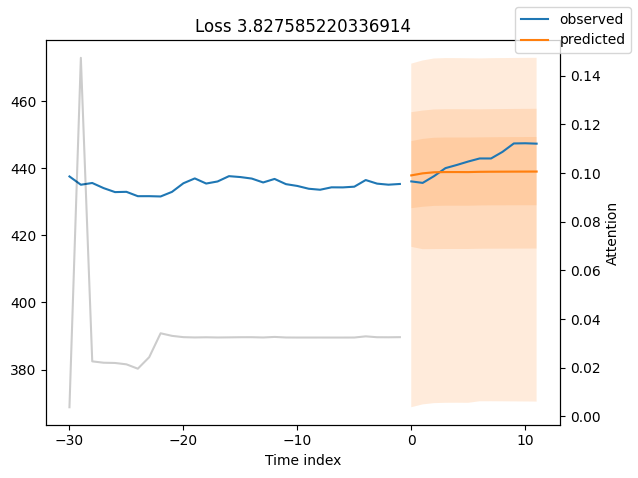

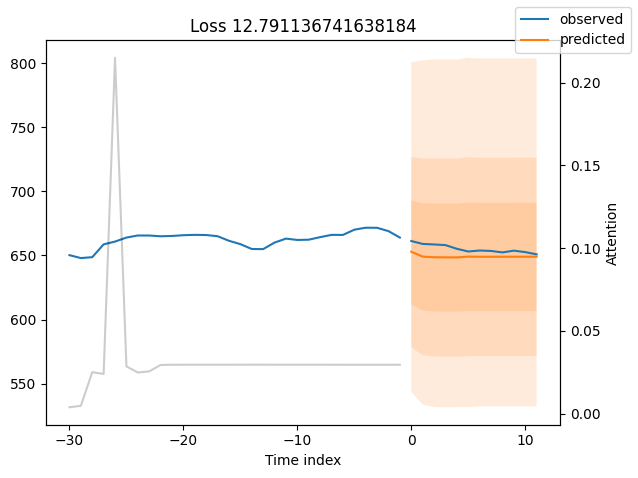

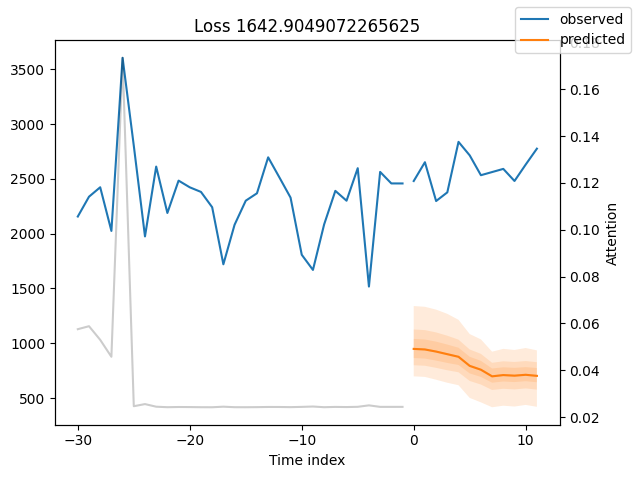

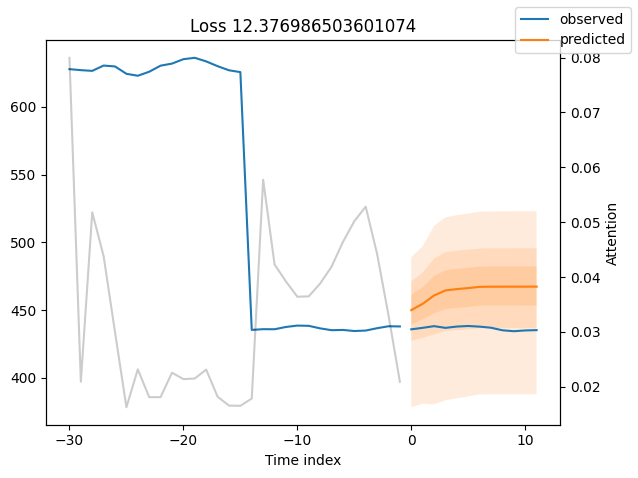

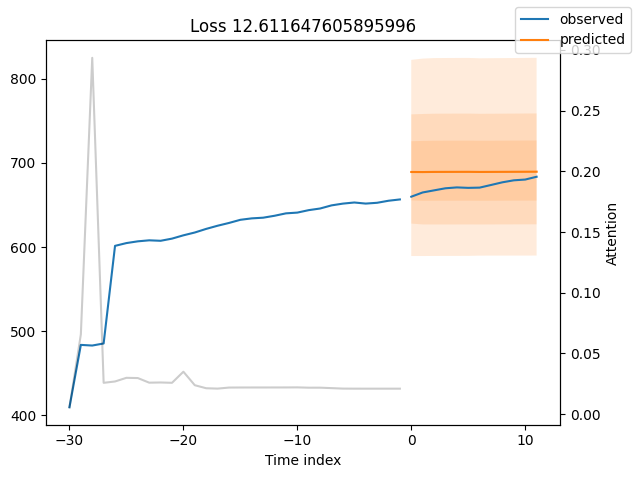

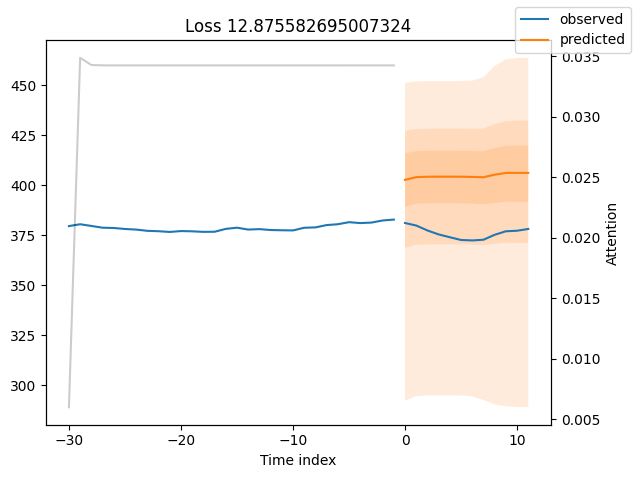

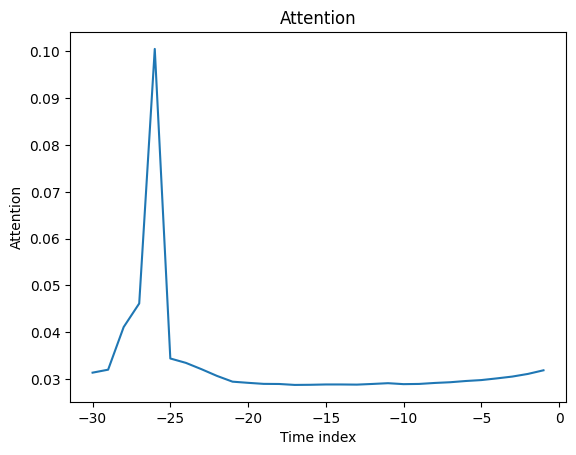

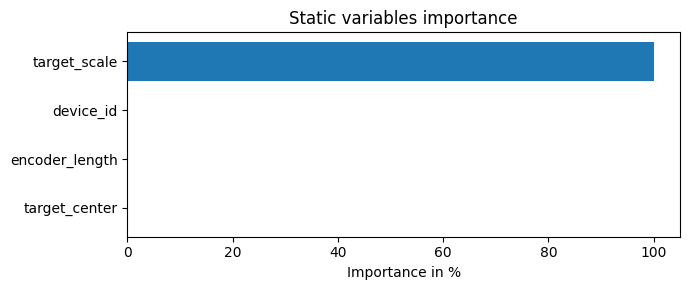

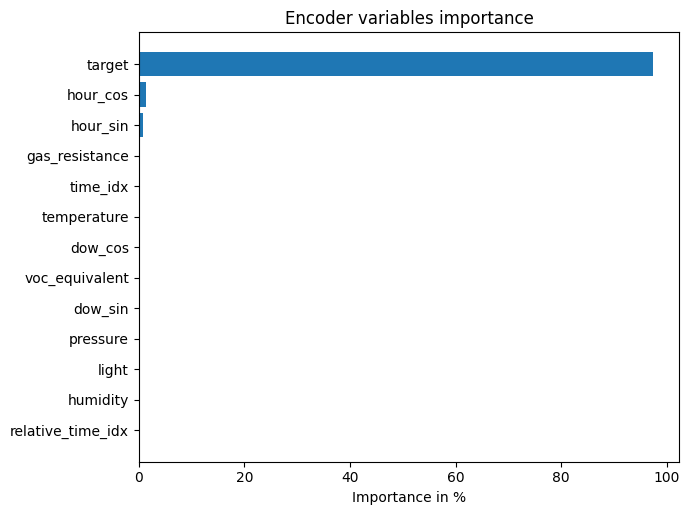

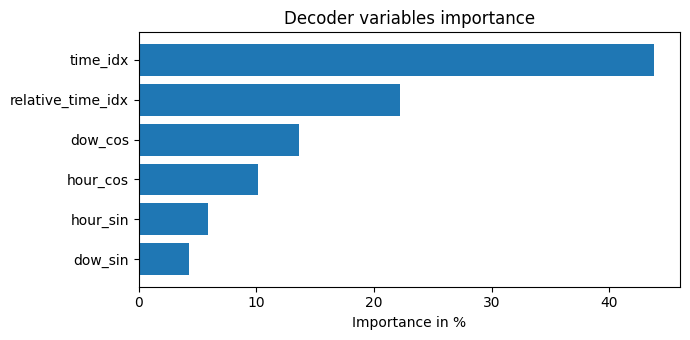

In [ ]:
# Plot sample predictions and interpretation
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True
)

# Get the number of predictions
num_predictions = len(raw_predictions.output["prediction"])

# Generate a list of random indices to plot
num_random_plots = min(6, num_predictions)  # Plot up to 6 random predictions
random_indices = np.random.choice(num_predictions, size=num_random_plots, replace=False)


for idx in random_indices:
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.show()

interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

In [ ]:
# Hyperparameter optimization with Optuna (adjust n_trials/epochs as needed)
import pickle

N_TRIALS = 30
MAX_EPOCHS = 30
MODEL_PATH = "tft_optuna"

study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    model_path=MODEL_PATH,
    n_trials=N_TRIALS,
    max_epochs=MAX_EPOCHS,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(16, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(1e-3, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=50),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

with open("tft_optuna_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print("Best trial params:\n", study.best_trial.params)

